# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, ReLU

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

# Hyperparams

In [2]:
HEIGHT, WIDTH, CHANNELS = 50, 200, 3
N_CLASSES = 2
VALIDATION_SPLIT = 0.1
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 5

# Utility

In [3]:
def plot_history(history, title):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Val'], loc='upper right')

    plt.show()

In [4]:
def plot_result(x, y, preds):
    batch_size = preds.shape[0]
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(batch_size):
        img = x[i]
        label = np.argmax(y[i])
        pred = np.argmax(preds[i])
        title = f"Pred: {pred} | True: {label}"
        
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
    plt.show()

# Model Structure

In [5]:
def build_model(input_shape, n_classes):
    inputs = Input(shape=input_shape, name="InputLayer")

    # Conv Block 1
    x = Conv2D(
        filters=32,
        kernel_size=(3, 3),
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(inputs)
    x = BatchNormalization(name="BN1")(x)
    x = ReLU(name="ReLU1")(x)
    x = MaxPool2D(
        pool_size=(2, 2),
        name="Pool1"
    )(x)
    x = Dropout(0.25)(x)

    # Conv Block 2
    x = Conv2D(
        filters=64,
        kernel_size=(3, 3),
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = BatchNormalization(name="BN2")(x)
    x = ReLU(name="ReLU2")(x)
    x = MaxPool2D(
        pool_size=(2, 2),
        name="Pool2"
    )(x)
    x = Dropout(0.25)(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((input_shape[0] // 4), (input_shape[1] // 4) * 64)

    x = Reshape(target_shape=new_shape, name="Reshape")(x)
    x = Dense(64, activation="relu", name="Dense1")(x)
    x = Dropout(0.25, name="Dropout1")(x)

    # RNNs
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.25))(x)

    # Output layer
    x = Dense(
        n_classes,
        activation="softmax",
        name="Dense2",
    )(x)
    
    model = Model(
        inputs=inputs,
        outputs=x,
        name="Classifier_Model"
    )

    return model

In [6]:
model = build_model(
    input_shape=(HEIGHT, WIDTH, CHANNELS),
    n_classes=N_CLASSES,
)
model.summary()

Model: "Classifier_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 InputLayer (InputLayer)     [(None, 50, 200, 3)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 50, 200, 32)       896       
                                                                 
 BN1 (BatchNormalization)    (None, 50, 200, 32)       128       
                                                                 
 ReLU1 (ReLU)                (None, 50, 200, 32)       0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 25, 100, 32)       0         
                                                                 
 dropout (Dropout)           (None, 25, 100, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 25, 100, 64)  

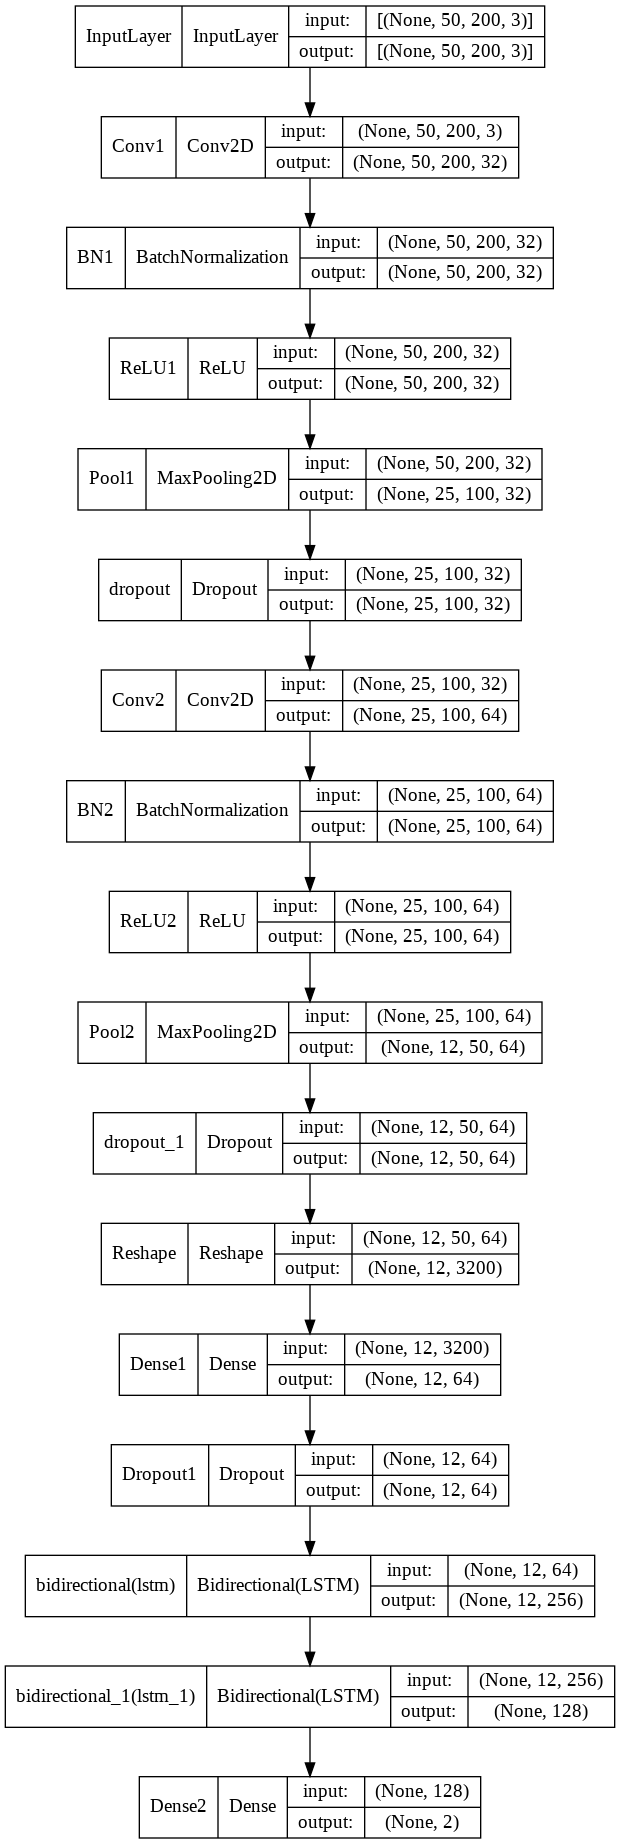

In [7]:
plot_model(
    model,
    to_file="Classifier_Model.png",
    show_shapes=True,
    show_layer_names=True
)

# Dataset

In [8]:
!gdown --id 1vJ8HUbgZvIlP867jxbeMhtXI5HAGSnbu
!unzip -qq -n Dataset.zip
!rm Dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1vJ8HUbgZvIlP867jxbeMhtXI5HAGSnbu
To: /content/Dataset.zip
100% 10.4M/10.4M [00:00<00:00, 37.2MB/s]


In [9]:
data_dir = 'Dataset/'

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT,
    brightness_range=[0.5, 1.0],
)

train_set = datagen.flow_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    class_mode='categorical',
    subset='training',
)

val_set = datagen.flow_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    class_mode='categorical',
    subset='validation',
)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# Compile and Fit

In [10]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    filepath="./checkpoints/classifier_model.hdf5",
	monitor='val_loss',
    mode='min',
    save_best_only=True,
)

In [11]:
history = model.fit(
    x=train_set,
    validation_data=val_set,
    epochs=EPOCHS,
    callbacks=[checkpoint],
)

Epoch 1/5
113/113 [==============================] - 62s 400ms/step - loss: 0.1530 - accuracy: 0.9294 - val_loss: 3.7396 - val_accuracy: 0.5050
Epoch 2/5
113/113 [==============================] - 46s 410ms/step - loss: 3.5781e-04 - accuracy: 1.0000 - val_loss: 1.5822 - val_accuracy: 0.7850
Epoch 3/5
113/113 [==============================] - 44s 386ms/step - loss: 1.8155e-04 - accuracy: 1.0000 - val_loss: 0.0471 - val_accuracy: 0.9900
Epoch 4/5
113/113 [==============================] - 45s 397ms/step - loss: 1.0804e-04 - accuracy: 1.0000 - val_loss: 4.7975e-05 - val_accuracy: 1.0000
Epoch 5/5
113/113 [==============================] - 44s 391ms/step - loss: 7.0407e-05 - accuracy: 1.0000 - val_loss: 3.2679e-05 - val_accuracy: 1.0000


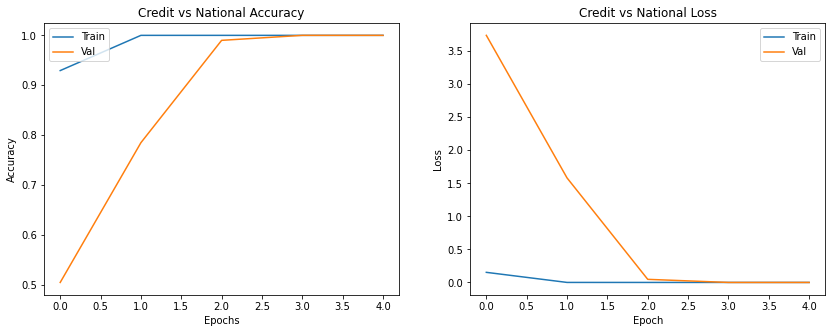

In [12]:
plot_history(history, 'Credit vs National')

# Evaluation

In [13]:
X_eval, Y_eval = next(val_set)
print(X_eval.shape)
print(Y_eval.shape)

(16, 50, 200, 3)
(16, 2)


In [14]:
model = load_model('./checkpoints/classifier_model.hdf5')
preds = model.predict(X_eval)

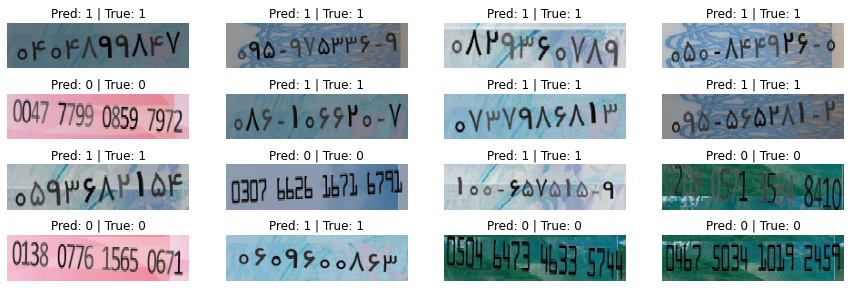

In [15]:
plot_result(X_eval, Y_eval, preds)